## TensorFlow 2.0_基于LSTM实现多变量预测_共享单车使用量预测
### 案例实现流程：

* 1. 加载数据集、数据可视化、预处理
* 2. 特征工程
* 3. 构建模型
* 4. 模型编译、训练、验证

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras import Sequential, layers, utils, losses
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import warnings
warnings.filterwarnings('ignore')

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### 第1步：加载数据集、预处理

In [27]:
# 加载数据集

dataset = pd.read_csv("BikeShares.csv", parse_dates=['timestamp'], index_col=['timestamp'])

In [4]:
# 数据集大小

dataset.shape

(17414, 9)

In [5]:
# 默认显示前5行

dataset.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [6]:
# 默认显示后5行

dataset.tail()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0
2017-01-03 23:00:00,139,5.0,1.0,76.0,22.0,2.0,0.0,0.0,3.0


#### 字段说明：

* timestamp : 时间戳
* cnt : 租用共享单车的数量（目标值）
* t1 : 气温
* t2 : 体感温度
* hum : 湿度
* wind_speed : 风速
* weather_code : 天气的类别（1=干净，2 =很少的云，3=碎云，4=多云，7=雨/小雨，10=有雷雨，26=降雪，94=冰雾）
* is_holiday : 是否为假期（1:假期 / 0:工作日）
* is_weekend : 是否为周末（1:周末 / 0：工作日）
* season : 季节（0:春天 ; 1:夏天 ; 2:秋天 ; 3:冬天）

In [7]:
# 数据集信息

dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17414 entries, 2015-01-04 00:00:00 to 2017-01-03 23:00:00
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cnt           17414 non-null  int64  
 1   t1            17414 non-null  float64
 2   t2            17414 non-null  float64
 3   hum           17414 non-null  float64
 4   wind_speed    17414 non-null  float64
 5   weather_code  17414 non-null  float64
 6   is_holiday    17414 non-null  float64
 7   is_weekend    17414 non-null  float64
 8   season        17414 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.3 MB


In [8]:
# 数据集描述

dataset.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


### 第2步：数据预处理

* 注意事项：
* 1. cnt : 是标签；
* 2. t1, t2, hum, wind_speed : 是数值类型字段；
* 3. weather_code, is_holiday, is_weekend, season : 是分类类型字段；

In [28]:
# 特征数据集
X = np.array(dataset.drop(columns=['cnt'], axis=1))

# 标签数据集
y = np.array(dataset['cnt'])

In [29]:
# 分类型字段独热编码
# features = pd.get_dummies(features)

# 对数值类型字段进行归一化
X = StandardScaler().fit_transform(X)
y = StandardScaler().fit_transform(y.reshape(-1,1))

In [30]:
X.shape

(17414, 8)

In [31]:
y.shape

(17414, 1)

### 第3步：模型搭建、编译、训练

- tensorflow集成了keras,常用参数如下：
- activation:激活函数，一般用relu;
- kernel_initializer,bias_initializer:权重和偏置的初始化方法，不收敛的话换换别的初始化方法（有点玄学）;
- input: 输入，可以自己指定也可以让网络自动选；
- units: 神经元个数

In [51]:
# 模型搭建
model = Sequential([
    layers.Dense(16,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.03)),
    layers.Dense(32,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.03)),
    layers.Dense(1,kernel_initializer='random_normal',kernel_regularizer=tf.keras.regularizers.l2(0.03)),
])
# 模型编译，指定优化器和损失函数等
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss='mse')
# 模型训练
model.fit(X,y,validation_split=0.25,epochs=10,batch_size=64)

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

205/205 [==============================] - 3s 15ms/step - loss: 0.7841 - val_loss: 0.9349
Epoch 2/10
205/205 [==============================] - 3s 15ms/step - loss: 0.7387 - val_loss: 0.9319
Epoch 3/10
205/205 [==============================] - 3s 14ms/step - loss: 0.7364 - val_loss: 0.9339
Epoch 4/10
205/205 [==============================] - 3s 13ms/step - loss: 0.7356 - val_loss: 0.9342
Epoch 5/10
205/205 [==============================] - 3s 14ms/step - loss: 0.7363 - val_loss: 0.9285
Epo

模型参数的计算：第一层输入特征为8，输出为16，那么8*16+16=144，第二层输入16，输出32，那么16*32+32=544，最后一层输入32，输出1，那么32*1+1=33.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  144       
_________________________________________________________________
dense_1 (Dense)              multiple                  544       
_________________________________________________________________
dense_2 (Dense)              multiple                  33        
Total params: 721
Trainable params: 721
Non-trainable params: 0
_________________________________________________________________


In [49]:
# 存模型

checkpoint_file = "best_model.hdf5"
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_file, 
                                      monitor='loss',
                                      mode='min',
                                      save_best_only=True,
                                      save_weights_only=True)

### 第6步：模型验证

In [52]:
test_preds = model.predict(X, verbose=1)

545/545 [==============================] - 2s 3ms/step


In [53]:
test_preds = test_preds[:, 0] # 获取列值
test_preds[:5]

array([-0.8943939, -0.8653515, -0.9397176, -1.0295827, -0.925081 ],
      dtype=float32)

In [54]:
y_true = y[:,0]

In [55]:
# 计算r2值

score = r2_score(y_true, test_preds)

print("r^2 值为： ", score)

r^2 值为：  0.2597041541540156


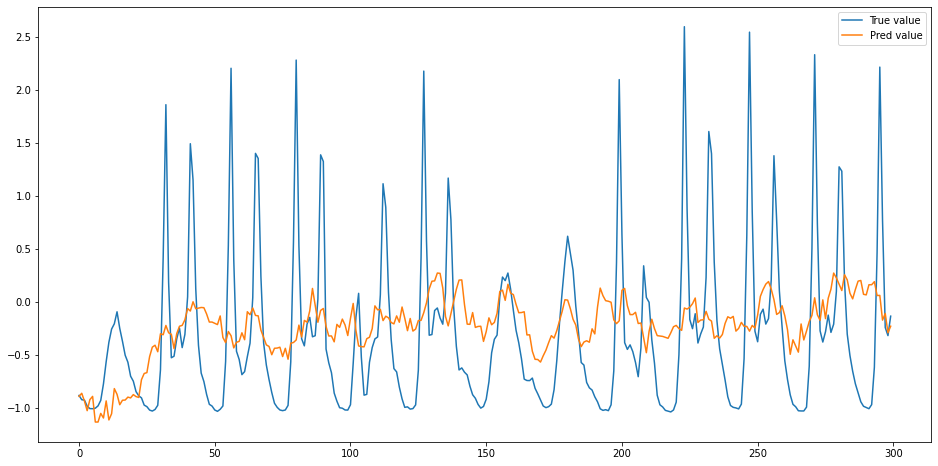

In [56]:
# 绘制 预测与真值结果

plt.figure(figsize=(16,8))
plt.plot(y_true[:300], label="True value")
plt.plot(test_preds[:300], label="Pred value")
plt.legend(loc='best')
plt.show()